# 1. Data

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import random_split
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train = datasets.CIFAR10(root ='./data', train=True, download=True, transform=transform)

test = datasets.CIFAR10(root ='./data', train=False, download=True, transform=transform)
train.data.shape

Files already downloaded and verified
Files already downloaded and verified


(50000, 32, 32, 3)

In [3]:
test.data.shape

(10000, 32, 32, 3)

In [4]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
def plot_sample(index):
  plt.imshow(train.data[index])
  plt.axis('on')
  label = train.targets[index]
  plt.title(f'Label: {classes[label]}')
  plt.show()

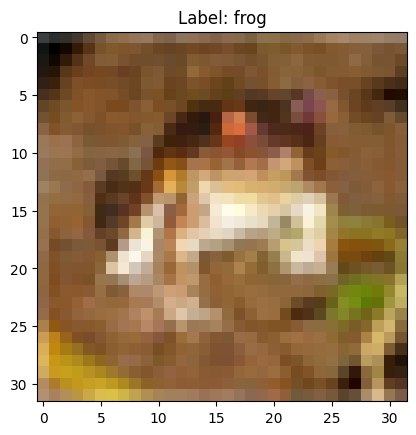

In [6]:
plot_sample(0)

Split into train, validation

In [7]:
num_train = 45000
num_valid = 5000
train_set, val_set = random_split(train, [num_train, num_valid])
print(len(val_set))
print(len(train_set))

5000
45000


In [8]:
BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

Check the training set distribution


In [9]:
total = 0
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for data in train_loader:
  Xs, Ys = data
  for y in Ys:
    counter_dict[int(y)] += 1
    total += 1

print(counter_dict)

{0: 4489, 1: 4533, 2: 4481, 3: 4515, 4: 4495, 5: 4496, 6: 4494, 7: 4508, 8: 4486, 9: 4503}


# 2. The Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10(nn.Module):
    def __init__(self):
        super(CIFAR10, self).__init__()
        self.cnn = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(512, 10),
            nn.Softmax(dim=-1)
        )


    def forward(self, x):
        x = self.cnn(x)

        return x

model = CIFAR10()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CIFAR10(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [11]:
from torchsummary import summary
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
       BatchNorm2d-7           [-1, 64, 16, 16]             128
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
             ReLU-10            [-1, 128, 8, 8]               0
      BatchNorm2d-11            [-1, 128, 8, 8]             256
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 256, 4, 4]         295,168
             ReLU-14            [-1, 25

# 3. Train

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.004)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [13]:
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0

    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()

        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)

    # print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')

    return train_loss, train_accuracy

In [14]:
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0

    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)

        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()

    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)

    # print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')

    return val_loss, val_accuracy

In [15]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

EPOCHS = 15

for epoch in range(EPOCHS):
    train_epoch_loss, train_epoch_accuracy = train(model, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(model, val_loader)
    scheduler.step()
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    print(f'Epoch {epoch}, Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}, Val acc: {val_epoch_accuracy:.2f}')


Epoch 0, Loss: 0.1346, Train Acc: 31.24, Val acc: 49.98
Epoch 1, Loss: 0.1222, Train Acc: 51.65, Val acc: 55.34
Epoch 2, Loss: 0.1180, Train Acc: 57.98, Val acc: 60.50
Epoch 3, Loss: 0.1150, Train Acc: 63.19, Val acc: 63.28
Epoch 4, Loss: 0.1133, Train Acc: 66.05, Val acc: 67.30
Epoch 5, Loss: 0.1115, Train Acc: 68.82, Val acc: 68.34
Epoch 6, Loss: 0.1097, Train Acc: 72.53, Val acc: 71.46
Epoch 7, Loss: 0.1081, Train Acc: 75.03, Val acc: 74.24
Epoch 8, Loss: 0.1068, Train Acc: 77.12, Val acc: 74.80
Epoch 9, Loss: 0.1057, Train Acc: 78.97, Val acc: 76.90
Epoch 10, Loss: 0.1024, Train Acc: 84.35, Val acc: 79.58
Epoch 11, Loss: 0.1011, Train Acc: 86.60, Val acc: 80.34
Epoch 12, Loss: 0.1005, Train Acc: 87.47, Val acc: 80.52
Epoch 13, Loss: 0.0999, Train Acc: 88.56, Val acc: 80.28
Epoch 14, Loss: 0.0994, Train Acc: 89.28, Val acc: 80.62


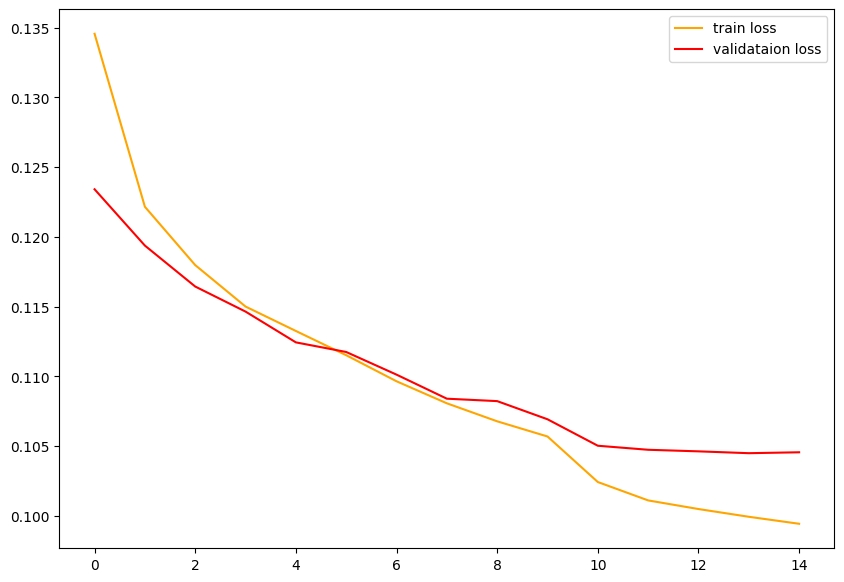

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

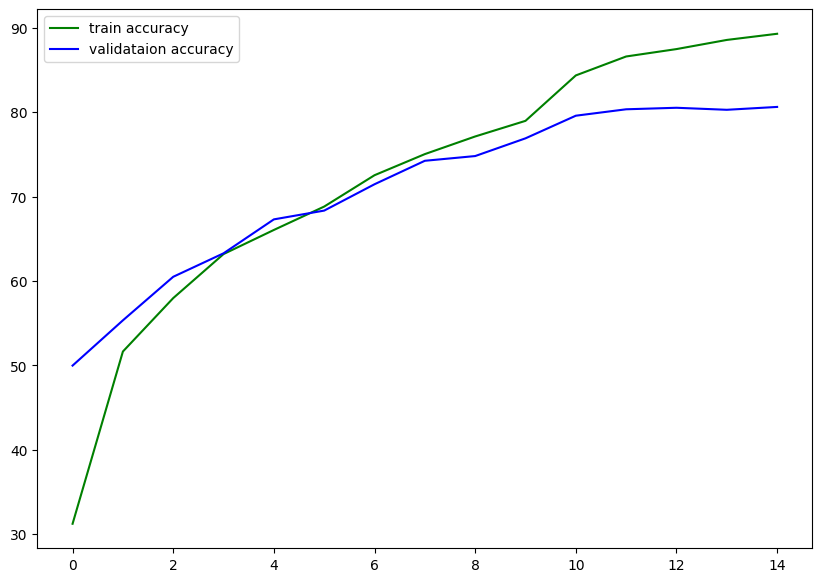

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# 4. Test

In [18]:
correct = 0
total = 0

with torch.no_grad():

  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of model: {100 * correct / total:.2f} %')

Accuracy of model: 80.06 %
